In [ ]:
#IMPORTING NECESSARY LIBRARIES
!pip install nltk
!pip install textblob
!pip install wordcloud
from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#LOADING THE  DATASET
df = pd.read_csv('/content/amazon_review.csv', sep=",")
print(df.head())

       reviewerID        asin  reviewerName helpful                                         reviewText  overall                                 summary  unixReviewTime  reviewTime  day_diff  helpful_yes  total_vote
0  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]                                         No issues.     4.00                              Four Stars      1406073600  2014-07-23       138            0           0
1  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]  Purchased this for my device, it worked as adv...     5.00                           MOAR SPACE!!!      1382659200  2013-10-25       409            0           0
2  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]  it works as expected. I should have sprung for...     4.00               nothing to really say....      1356220800  2012-12-23       715            0           0
3   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]  This think has worked out great.Had a diff. br...     5.00  Great buy at this price!!! 

In [ ]:
 #TEXT PREPROCESSING
 def text_preprocessing(dataframe, dependent_var):
  # Normalizing Case Folding - Uppercase to Lowercase
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
   # Removing Punctuation
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')
   # Removing Numbers
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')
   # StopWords
  sw = stopwords.words('english')
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
   # Remove Rare Words
  temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))
    # Lemmatize
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  return dataframe

In [ ]:
df = text_preprocessing(df, "reviewText")

In [ ]:
df["reviewText"].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

In [ ]:
#TEXT VISUALIZATION
def text_visulaization(dataframe, dependent_var, barplot=True, wordcloud=True):
  # Calculation of Term Frequencies
  tf = dataframe[dependent_var].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
  tf.columns = ["words", "tf"]
  if barplot:
    # Bar Plot
    tf[tf["tf"]>1000].plot.barh(x="words", y="tf")
    plt.title("Calculation of Term Frequencies : barplot")
    plt.show()
  if wordcloud:
    # WordCloud
    text = " ".join(i for i in dataframe[dependent_var])
    wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(text)
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Calculation of Term Frequencies : wordcloud")
    plt.show()
    wordcloud.to_file("wordcloud.png")

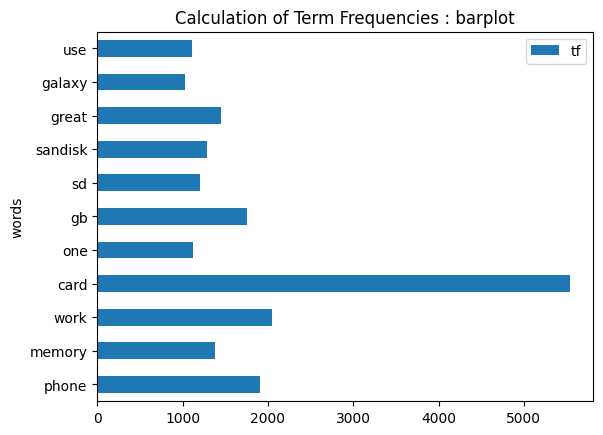

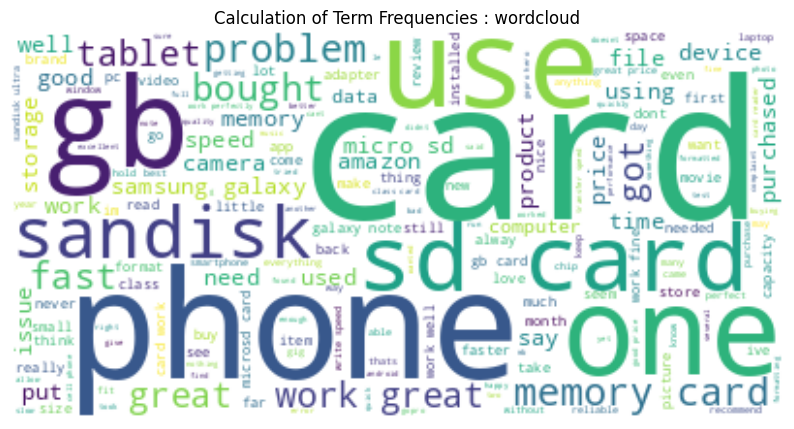

In [ ]:
text_visulaization(df, "reviewText")

In [ ]:
#SENTIMENT ANALYSIS
def create_polarity_scores(dataframe, dependent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe["polarity_score"] = dataframe[dependent_var].apply(lambda x: sia.polarity_scores(x)["compound"])

In [ ]:
create_polarity_scores(df, "reviewText")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86


In [ ]:
#FEATURE ENGINEERING
# Create Lables
def create_label(dataframe, dependent_var, independent_var):
  sia = SentimentIntensityAnalyzer()
  dataframe[independent_var] = dataframe[dependent_var].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
  dataframe[independent_var] = LabelEncoder().fit_transform(dataframe[independent_var])

  X = dataframe[dependent_var]
  y = dataframe[independent_var]

  return X, y

In [ ]:
X, y = create_label(df, "reviewText", "sentiment_label")

In [ ]:
# Split Dataset
def split_dataset(dataframe, X, y):
  train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=1)
  return train_x, test_x, train_y, test_y

In [ ]:
train_x, test_x, train_y, test_y = split_dataset(df, X, y)

In [ ]:
def create_features_count(train_x, test_x):
  # Count Vectors
  vectorizer = CountVectorizer()
  x_train_count_vectorizer = vectorizer.fit_transform(train_x)
  x_test_count_vectorizer = vectorizer.fit_transform(test_x)

  return x_train_count_vectorizer, x_test_count_vectorizer

In [ ]:
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)

In [ ]:
def create_features_TFIDF_word(train_x, test_x):
  # TF-IDF word
  tf_idf_word_vectorizer = TfidfVectorizer()
  x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(train_x)
  x_test_tf_idf_word = tf_idf_word_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_word, x_test_tf_idf_word

In [ ]:
x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)

In [ ]:
#SENTIMENT MODELING - CREATE MODEL
#Logistic Regression
def crate_model_logistic(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  log_count = LogisticRegression(solver='lbfgs', max_iter=1000)
  log_model_count = log_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(log_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  log_word = LogisticRegression(solver='lbfgs', max_iter=1000)
  log_model_word = log_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(log_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  return log_model_count, log_model_word

In [ ]:
log_model_count, log_model_word = crate_model_logistic(train_x, test_x)

Accuracy - Count Vectors: 0.832
Accuracy - TF-IDF Word: 0.801


In [ ]:
# Random Forest
def crate_model_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_count = RandomForestClassifier()
  rf_model_count = rf_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  rf_word = RandomForestClassifier()
  rf_model_word = rf_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  print("Accuracy - TF-IDF Word: %.3f" % accuracy_word)

  return rf_model_count, rf_model_word

In [ ]:
rf_model_count, rf_model_word = crate_model_randomforest(train_x, test_x)

Accuracy - Count Vectors: 0.813
Accuracy - TF-IDF Word: 0.806


In [ ]:
#PREDICTION
def predict_count(train_x, model, new_comment):
  new_comment= pd.Series(new_comment)
  new_comment = CountVectorizer().fit(train_x).transform(new_comment)
  result = model.predict(new_comment)
  if result==1:
    print("Comment is Positive")
  else:
    print("Comment is Negative")

In [ ]:
# Logistic Regression
predict_count(train_x, model=log_model_count, new_comment="this product is very nice :)")

Comment is Positive


In [ ]:
# Random Forest
predict_count(train_x, model=rf_model_count, new_comment="this product is worst :)")

Comment is Negative


In [ ]:
# Sample Review
new_comment=pd.Series(df["reviewText"].sample(1).values)
new_comment

0    reasonably priced product work well never prob...
dtype: object

In [ ]:
# Sample Review - Random Forest
predict_count(train_x, model=rf_model_count, new_comment=new_comment)

Comment is Positive
